In [376]:
import preprocessing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import sqlite3
import seaborn as sns
import graphviz 
import matplotlib.pyplot as plt

In [84]:
filePath="./data/financial.db"
# dataframe = preprocessing.loadAllData(filePath)

In [364]:
def extractXYValues(df, yVectorName):
    notNanDF = df[ df[yVectorName].notna() ]
    yValues = notNanDF[yVectorName]
    xValues = notNanDF.loc[:, notNanDF.columns != yVectorName] 

    one_hot_Xdata = pd.get_dummies(xValues)

    return (one_hot_Xdata, yValues)

def getTrainTestSplit(xValues, yValues): 
    X_train, X_test, y_train, y_test = train_test_split(xValues, yValues, test_size=0.33, random_state=42)

    return (X_train, X_test, y_train, y_test)


def accChangeToDemo(filepath):
    """
        Creates column to be added to demographic table. Column is taken from the 
        summed difference of the median account balances by district (1994-1998)
        relative to the median account value in all data in 1994.
    Args:
        filepath (str): path to financial.db.
    """
    conn = sqlite3.connect(filepath)
    accdist = pd.read_sql_query("SELECT account_id, district_id from account", conn)
    df = pd.read_sql_query("SELECT date as 'y-m-d', balance, account_id from trans ", conn)
    from datetime import date
    df['y-m-d'] = pd.to_datetime(df['y-m-d'])
    df['year'] = df['y-m-d'].map(lambda x: x.strftime('%Y'))
    df = pd.merge(accdist, df, on='account_id')
    
    # Gets the average value of each account per id per district per year
    acctMedianPerAcctPerYearPerDistrict = df.groupby(['year', 'district_id', 'account_id'])[['balance']].median()

    # Calculates median/average account balance of each district per year
    medianAcct = acctMedianPerAcctPerYearPerDistrict.groupby(['year', 'district_id'])[['balance']].median()
    avgAcct = acctMedianPerAcctPerYearPerDistrict.groupby(['year', 'district_id'])[['balance']].mean()
    
    
    # Gets difference of each account's median per year
#     districtchange = average.groupby(['district_id'])[['balance']].diff().fillna(0)
#     asum = districtchange.groupby(['district_id'])[['balance']].sum()
#     newdemo = asum.div(302.70801242)

    return (acctMedianPerAcctPerYearPerDistrict.reset_index(), medianAcct.reset_index(), avgAcct.reset_index()) 

def categorizeGrowth(growthRate): 
    if growthRate > 10: 
        return 0
    elif growthRate >= 0: 
        return 1
    elif growthRate >= -10:
        return 2
    else: 
        return 3


def doKfoldCrossValidation(X,y, model, isRegression):     
    kf = KFold(n_splits=5, random_state=None, shuffle=True)
    errorRates = []
    for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
        X_train, X_test = X[train_index, :], X[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        mlModel = model()
        mlModel.fit(X_train, y_train)
        y_test_pred = mlModel.score(X_test, y_test)
        # Save off y_test_pred in a list or something -- you can average it all when done
        
#         if isRegression: 
#             errorRates.append( np.mean(np.abs(y_test.reshape((len(y_test),)) - y_test_pred) ))
#         else: 
#             errorRates.append( np.sum(y_test.reshape((len(y_test),)) == y_test_pred)/len(y_test_pred) )
        errorRates.append(y_test_pred)

    return np.mean(errorRates)


def getDataFrame(filePath): 
    (acctMedianPerAcctPerYearPerDistrict, medianPerDistrictDF, averagePerDistrictDF) = accChangeToDemo(filePath)
    conn = sqlite3.connect(filePath)
    districtDFNoNames = pd.read_sql_query("SELECT * from district", conn)
    conn.close()
    districtDF = updateColumnNames(districtDFNoNames)
    print(districtDF.columns)
    percentChangedDF.rename(columns={'balance': 'percentChanged'}, inplace=True)
    mergedDF = districtDF.merge(acctMedianPerAcctPerYearPerDistrict, on=["district_id"])
    df = mergedDF.drop(['districtName', 'region'], axis=1)
   
    df.dropna(inplace=True)
    return df

def applyModelToDataframe(df, xColumnsArray, yVectorName, model, isRegression): 

    X = df[xColumnsArray].values
    y = df[yVectorName].values.reshape((len(df[yVectorName],))) if isRegression else df[yVector].apply(categorizeGrowth).values.reshape((len(df[yVectorName],)))

    kFoldAccuracy = doKfoldCrossValidation(X,y, model, isRegression)

    return kFoldAccuracy

def updateColumnNames(df): 
    columnNames = ['district_id','districtName','region', 'numInhabitants', 
                   'municipalitiesLess500','municipalities500to2k','municipalities2kto10k',
                   'municipalitiesGreater10k','numCities','ratioUrbanInhabitants','avgSalary',
                   'unEmployment95','unEmployment96','entrepeneursPer1k','crimesIn95','crimesIn96' ] 
    df.columns = columnNames
        
    return df

In [373]:
someDF = getDataFrame(filePath)
allXColumns = ['district_id','numInhabitants', 'municipalitiesLess500','municipalities500to2k','municipalities2kto10k','municipalitiesGreater10k','numCities',                   
           'ratioUrbanInhabitants','avgSalary','unEmployment95','unEmployment96', 'entrepeneursPer1k', 'crimesIn95', 'crimesIn96' ] 
yVector = ['balance']

Index(['district_id', 'districtName', 'region', 'numInhabitants',
       'municipalitiesLess500', 'municipalities500to2k',
       'municipalities2kto10k', 'municipalitiesGreater10k', 'numCities',
       'ratioUrbanInhabitants', 'avgSalary', 'unEmployment95',
       'unEmployment96', 'entrepeneursPer1k', 'crimesIn95', 'crimesIn96'],
      dtype='object')


In [374]:
randomForestAccuracy = applyModelToDataframe(someDF, allXColumns, yVector, RandomForestRegressor, True)

In [375]:
randomForestAccuracy

0.00011033243278477656

In [353]:
randomForestAccuracy
someDF

,district_id,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,year,account_id,balance
0,1,1204953,0,0,0,1,1,100.0,12541,0.2,0.43,167,85677.0,99107,1993,2,31258.5
1,1,1204953,0,0,0,1,1,100.0,12541,0.2,0.43,167,85677.0,99107,1993,36,42766.0
2,1,1204953,0,0,0,1,1,100.0,12541,0.2,0.43,167,85677.0,99107,1993,186,34015.0
3,1,1204953,0,0,0,1,1,100.0,12541,0.2,0.43,167,85677.0,99107,1993,197,43683.5
4,1,1204953,0,0,0,1,1,100.0,12541,0.2,0.43,167,85677.0,99107,1993,225,24958.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17541,77,148545,8,35,12,3,4,53.5,8909,4.0,5.56,113,3460.0,3590,1998,4631,73226.0
17542,77,148545,8,35,12,3,4,53.5,8909,4.0,5.56,113,3460.0,3590,1998,5228,70276.0
17543,77,148545,8,35,12,3,4,53.5,8909,4.0,5.56,113,3460.0,3590,1998,5817,57957.0
17544,77,148545,8,35,12,3,4,53.5,8909,4.0,5.56,113,3460.0,3590,1998,7181,72448.0


In [188]:
percentChangedDF = accChangeToDemo(filePath)

In [189]:
conn = sqlite3.connect(filePath)
districtDF = pd.read_sql_query("SELECT * from district", conn)

In [190]:
percentChangedDF.rename(columns={'balance': 'percentChanged'}, inplace=True)

In [191]:
mergedDF = districtDF.merge(percentChangedDF, on=["district_id"])

In [192]:
# indexedDistricts = mergedDF.set_index(['district_id'])
indexedDistricts = mergedDF
df = indexedDistricts.drop(['district_id', 'A2', 'A3'], axis=1)
# df['percentChanged'] = df['percentChanged'].apply(categorizeGrowth)

In [205]:
X = df.loc[:, df.columns != 'percentChanged']
# X = df.loc[:, ['A11','A12' ,'A13','A15','A16','A14']]
# X = df[['A11']].values
yUnshaped = df.loc[:, df.columns == 'percentChanged']
treeClassifier = tree.DecisionTreeClassifier()

In [206]:
y = yUnshaped#.reshape((len(yUnshaped),))

In [208]:
# Drew suggestions:
# For regression: 
#      - give table without aggregation - percent change per account - learn district from that 
#      - Random forest regressor/regression  
#.       if doing random forest using the .coef 

# Use OLS: 
#      - sklearn.linearRegression


# Stepwise regression / sequential regression
# 
df

,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,percentChanged
0,1204953,0,0,0,1,1,100.0,12541,0.2,0.43,167,85677.0,99107,-53.192741
1,88884,80,26,6,2,5,46.7,8507,1.6,1.85,132,2159.0,2674,-69.530230
2,75232,55,26,4,1,5,41.7,8980,1.9,2.21,111,2824.0,2813,-113.667532
3,149893,63,29,6,2,6,67.4,9753,4.6,5.05,109,5244.0,5892,-66.132741
4,95616,65,30,4,1,6,51.4,9307,3.8,4.43,118,2616.0,3040,-95.782198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,182027,17,49,12,2,7,56.4,8746,3.3,3.74,90,4355.0,4433,-58.275734
73,323870,0,0,0,1,1,100.0,10673,4.7,5.44,100,18782.0,18347,-51.162989
74,138032,67,30,4,2,5,64.6,8819,5.3,5.66,99,4063.0,4505,354.178303
75,127369,31,32,13,2,7,51.2,8369,4.7,5.88,107,3736.0,2807,-70.036111


In [201]:
# treeClassifier = treeClassifier.fit(X,y)

In [334]:
# from matplotlib import pyplot 
# pyplot.figure(dpi=1000)
# tree.plot_tree(treeClassifier, feature_names=df.columns)

# pyplot.show()
npX = X.values
npy = y.values



In [335]:
kf = KFold(n_splits=5, random_state=None, shuffle=True)
errorRates = []


for fold, (train_index, test_index) in enumerate(kf.split(npX, npy)):
    X_train, X_test = npX[train_index, :], npX[test_index, :]
    y_train, y_test = npy[train_index], npy[test_index]
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    y_test_pred = rf.predict(X_test)
    # Save off y_test_pred in a list or something -- you can average it all when done
    print(f"y_test: {y_test.shape}")
    print(f"y_test_pred: {y_test_pred.shape}\n")
    errorRates.append( np.mean(np.abs(y_test.reshape((len(y_test),)) - y_test_pred) ))
    

<ipython-input-335-d813b3683eb9>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


y_test: (16, 1)
y_test_pred: (16,)



<ipython-input-335-d813b3683eb9>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


y_test: (16, 1)
y_test_pred: (16,)



<ipython-input-335-d813b3683eb9>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


y_test: (15, 1)
y_test_pred: (15,)



<ipython-input-335-d813b3683eb9>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


y_test: (15, 1)
y_test_pred: (15,)



<ipython-input-335-d813b3683eb9>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


y_test: (15, 1)
y_test_pred: (15,)



In [336]:
np.mean(errorRates)

591.2967495850627

In [337]:
X

,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,1204953,0,0,0,1,1,100.0,12541,0.2,0.43,167,85677.0,99107
1,88884,80,26,6,2,5,46.7,8507,1.6,1.85,132,2159.0,2674
2,75232,55,26,4,1,5,41.7,8980,1.9,2.21,111,2824.0,2813
3,149893,63,29,6,2,6,67.4,9753,4.6,5.05,109,5244.0,5892
4,95616,65,30,4,1,6,51.4,9307,3.8,4.43,118,2616.0,3040
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,182027,17,49,12,2,7,56.4,8746,3.3,3.74,90,4355.0,4433
73,323870,0,0,0,1,1,100.0,10673,4.7,5.44,100,18782.0,18347
74,138032,67,30,4,2,5,64.6,8819,5.3,5.66,99,4063.0,4505
75,127369,31,32,13,2,7,51.2,8369,4.7,5.88,107,3736.0,2807


In [338]:
rf = RandomForestRegressor()
rf.fit(X,y)

<ipython-input-338-907ad25d64e7>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X,y)


RandomForestRegressor()

Feature ranking:
1. feature 5 (0.333553)
2. feature 6 (0.088009)
3. feature 9 (0.086636)
4. feature 8 (0.085889)
5. feature 11 (0.069646)
6. feature 1 (0.064090)
7. feature 10 (0.054439)
8. feature 7 (0.053266)
9. feature 0 (0.049956)
10. feature 12 (0.046719)
11. feature 4 (0.033610)
12. feature 2 (0.023987)
13. feature 3 (0.010200)


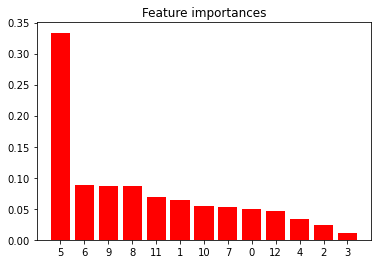

In [339]:
importances = rf.feature_importances_
std = np.std([rf.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [346]:
# somedf=accChangeToDemo(filePath)
X.columns[5]

'A9'

In [269]:
somedf.loc['1993']

balance
district_id account_id              
1           2           32590.759259
            36          42288.833333
            186         32719.357143
            197         45722.791667
            225         23421.388889
...                              ...
77          1972        23381.382979
            3157        14382.222222
            4119        11167.571429
            5228        66845.555556
            8321        33173.529412

[1139 rows x 1 columns]

In [270]:
len(somedf)

17546

In [289]:
dfthing = getDataFrame(filePath)

<class 'pandas.core.frame.DataFrame'>


In [290]:
dfthing.head()

,district_id,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,year,account_id,percentChanged
0,1,1204953,0,0,0,1,1,100.0,12541,0.2,0.43,167,85677.0,99107,1993,2,32590.759259
1,1,1204953,0,0,0,1,1,100.0,12541,0.2,0.43,167,85677.0,99107,1993,36,42288.833333
2,1,1204953,0,0,0,1,1,100.0,12541,0.2,0.43,167,85677.0,99107,1993,186,32719.357143
3,1,1204953,0,0,0,1,1,100.0,12541,0.2,0.43,167,85677.0,99107,1993,197,45722.791667
4,1,1204953,0,0,0,1,1,100.0,12541,0.2,0.43,167,85677.0,99107,1993,225,23421.388889


In [291]:
clf = RandomForestRegressor()

In [305]:
A = dfthing.dropna()[allXColumns].values
b = dfthing.dropna()[yVector].values.reshape((len(dfthing.dropna()[yVector],)))

In [309]:
clf.fit(X_train,y_train)

RandomForestRegressor()

In [310]:
clf.score(X_test, y_test)

0.002196071926265586

In [312]:
categoricalX = ['percentChanged', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16']
categoricalY = ['district_id']

In [314]:
rfClassifier = RandomForestClassifier()

In [316]:
A = dfthing.dropna()[categoricalX].values
b = dfthing.dropna()[categoricalY].values.reshape((len(dfthing.dropna()[yVector],)))
X_train, X_test, y_train, y_test = train_test_split(A, b, test_size=0.25)

In [347]:
rfClassifier.fit(X_train,y_train)
rfClassifier.fit()

<ipython-input-347-f6d0621363f0>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfClassifier.fit(X_train,y_train)


ValueError: Unknown label type: 'continuous'

In [ ]:
import sklean.